In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [174]:
df1 = pd.read_csv('/home/sasidharreddy/study/OELP_sem6/data.csv')
df=df1[['idates','imonths','iyears','obs']]
df.to_csv('new_output_file.csv', index=False)
df['datetime'] = pd.to_datetime( df['idates'].astype(str)+ '-' + df['imonths'].astype(str)+'-'+df['iyears'].astype(str))
df = df.drop(['idates', 'imonths', 'iyears'], axis=1)
df.to_csv('output_file.csv', index=False)

df = df.set_index('datetime')
df.index = pd.to_datetime(df.index)

/tmp/ipykernel_6330/1578682063.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime'] = pd.to_datetime( df['idates'].astype(str)+ '-' + df['imonths'].astype(str)+'-'+df['iyears'].astype(str))


In [175]:

df.head()

obs
datetime       
2007-01-01  0.0
2007-02-01  0.0
2007-03-01  0.0
2007-04-01  0.0
2007-05-01  0.0

In [176]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='precipitation values')
plt.show()

In [177]:
train = df.loc[df.index < '01-01-2018']
test = df.loc[df.index >= '01-01-2018']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2018', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [178]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

In [179]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [180]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='quarter', y='obs')
ax.set_title('quaterly')
plt.show()

In [181]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='obs', palette='Blues')
ax.set_title(' by Month')
plt.show()

/tmp/ipykernel_6330/649993264.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='obs', palette='Blues')


In [182]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'obs'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [183]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=9,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=10)

[0]	validation_0-rmse:12.66377	validation_1-rmse:12.34741
[10]	validation_0-rmse:12.20136	validation_1-rmse:12.20124
[20]	validation_0-rmse:11.78779	validation_1-rmse:12.08144
[30]	validation_0-rmse:11.41550	validation_1-rmse:11.98508


/home/sasidharreddy/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [18:30:21] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[40]	validation_0-rmse:11.08207	validation_1-rmse:11.89487
[50]	validation_0-rmse:10.78868	validation_1-rmse:11.80930
[60]	validation_0-rmse:10.51758	validation_1-rmse:11.74673
[70]	validation_0-rmse:10.27353	validation_1-rmse:11.70870
[80]	validation_0-rmse:10.05321	validation_1-rmse:11.67711
[90]	validation_0-rmse:9.84930	validation_1-rmse:11.64842
[100]	validation_0-rmse:9.66865	validation_1-rmse:11.63227
[110]	validation_0-rmse:9.48516	validation_1-rmse:11.62716
[120]	validation_0-rmse:9.29214	validation_1-rmse:11.61394
[130]	validation_0-rmse:9.10979	validation_1-rmse:11.61321
[140]	validation_0-rmse:8.94093	validation_1-rmse:11.63432
[150]	validation_0-rmse:8.78954	validation_1-rmse:11.68690
[160]	validation_0-rmse:8.64650	validation_1-rmse:11.75171
[170]	validation_0-rmse:8.51301	validation_1-rmse:11.81272
[173]	validation_0-rmse:8.47897	validation_1-rmse:11.84204


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

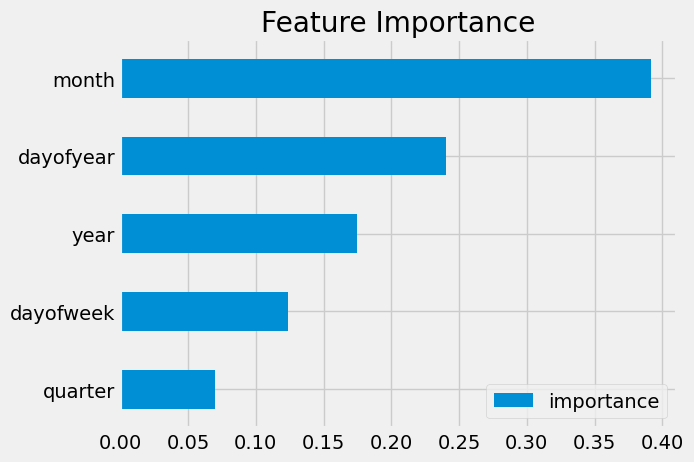

In [184]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

<AxesSubplot:xlabel='datetime'>

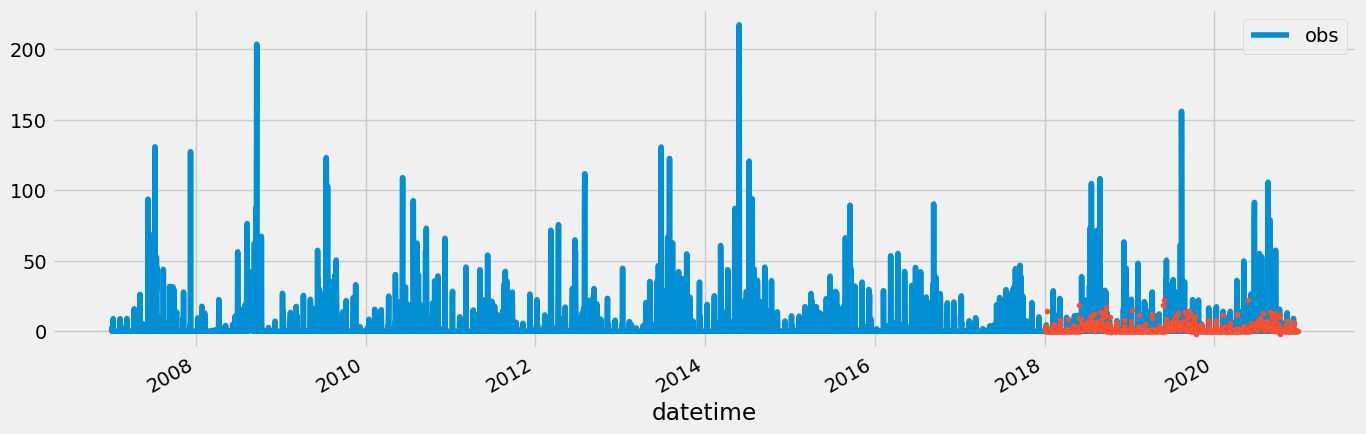

In [185]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['obs']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')



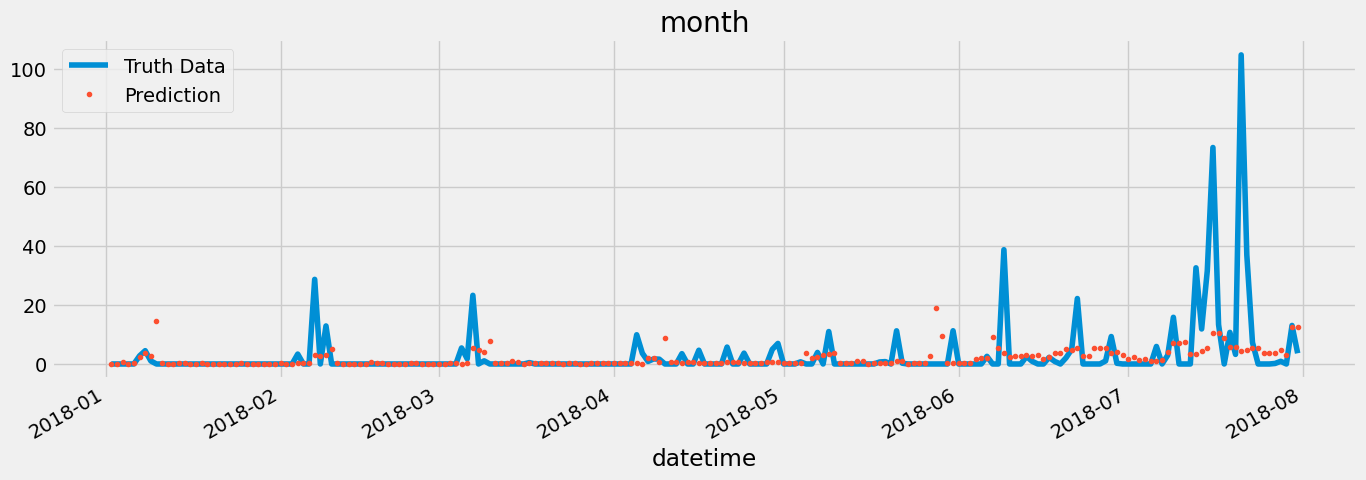

In [186]:
ax = df.loc[(df.index > '01-2018') & (df.index < '08-2018')]['obs'] \
    .plot(figsize=(15, 5), title='month')
df.loc[(df.index > '01-2018') & (df.index < '08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [187]:
score = np.sqrt(mean_squared_error(test['obs'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 11.60


In [191]:
test['obs']

datetime
2018-01-01    0.0
2018-02-01    0.0
2018-03-01    0.0
2018-04-01    0.0
2018-05-01    0.0
             ... 
2020-12-21    0.0
2020-12-22    0.0
2020-12-23    0.0
2020-12-24    0.0
2020-12-25    0.0
Name: obs, Length: 1089, dtype: float64

In [188]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(100)

date
2019-08-13    149.413409
2018-07-21    100.252516
2020-08-20     99.729853
2018-08-27     94.866251
2020-06-22     86.091171
                 ...    
2020-09-12     11.351186
2020-06-16     11.309692
2020-02-08     11.260492
2020-04-09     11.224131
2019-09-18     11.193380
Name: error, Length: 100, dtype: float64